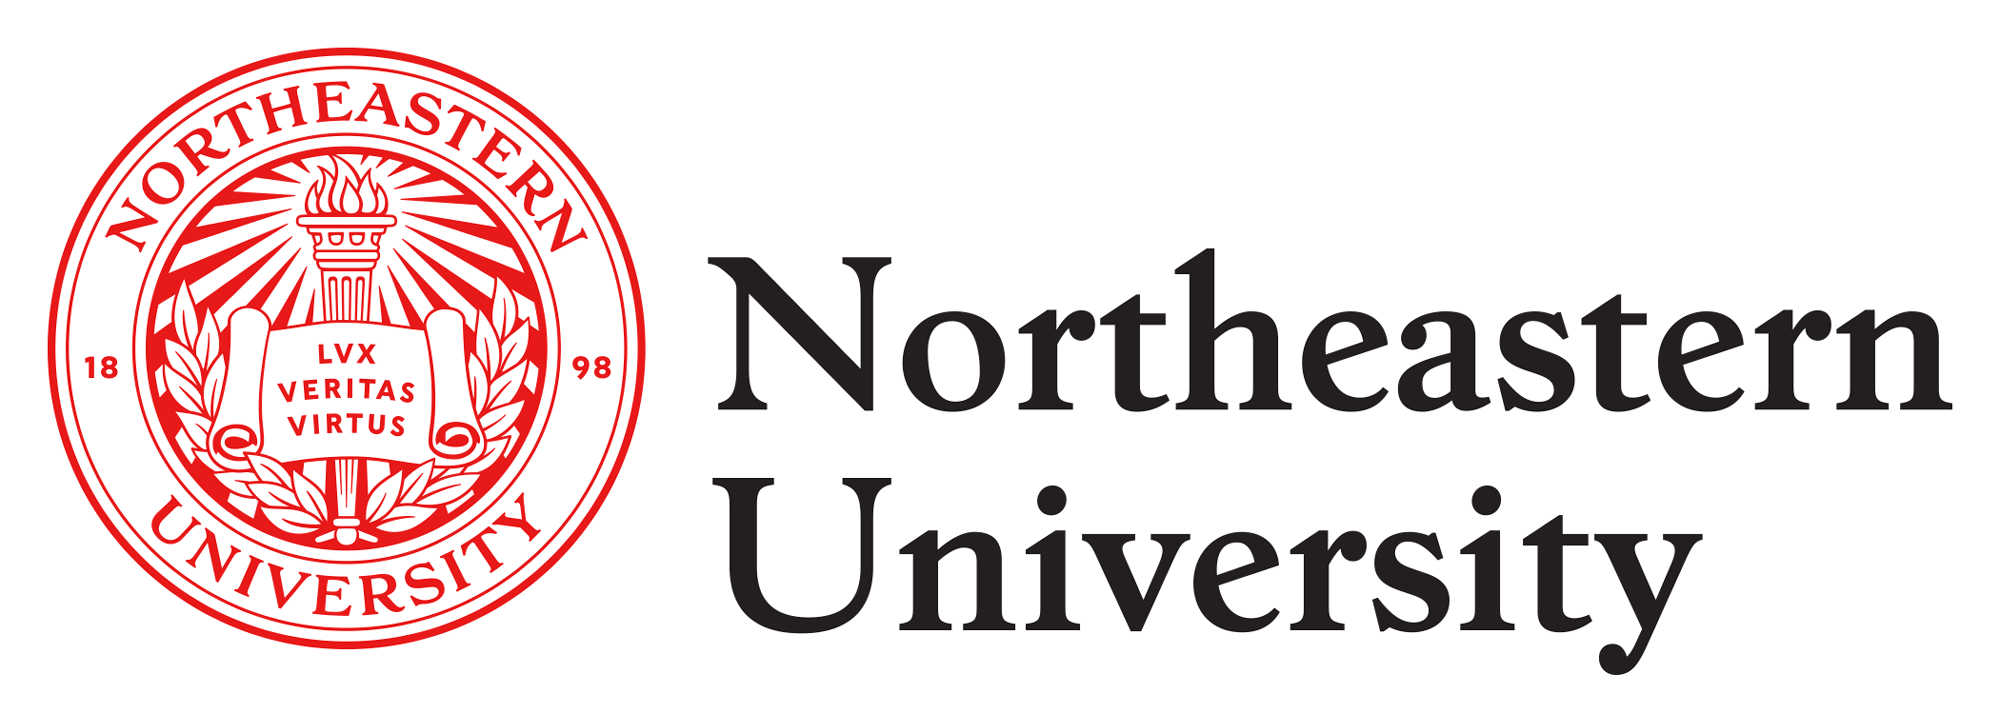

# MA 7243 Machine Learning Project 

## Vehicle Speed Estimation Using Optic Flow - FlowNetS

### Author: Tigran Melkonian
### NUID: 001363807
### Email: melkonian.t@northeastern.edu
### Date: 4/24/2021

## Imports

In [1]:
#Import libraries/packages
import os
import cv2
import h5py 
import pickle
import ipywidgets
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import skvideo.io
import skvideo.datasets
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# #Import utility functions
from utils import *
from models.optical_flow.flowNetS_model import  flowNetS_model
from models.optical_flow.nvidia_model import  nvidia_model

In [3]:
#Creating keras ML enviroment - TF GPU with keras as backend
from tensorflow import keras as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Layer,Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, Lambda, ELU, Conv2DTranspose, Concatenate,Input, LeakyReLU, ZeroPadding2D,ZeroPadding3D,concatenate,Reshape,UpSampling2D, Dot, Convolution2D

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6723866384513275124
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12573012549493409745
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3129973147
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10572018368956115259
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6817367957903148367
physical_device_desc: "device: XLA_GPU device"
]


## Data 

In [4]:
# Defining local paths for reads and writes
DATA_PATH = 'data'
TRAIN_VIDEO = f'{DATA_PATH}\\train.mp4'
CLEAN_DATA_PATH = 'data\\clean_data'
CLEAN_IMGS_TRAIN = f'{CLEAN_DATA_PATH}\\train_imgs'
ASSETS_PATH = f'{CLEAN_DATA_PATH}\\assets'

TRAIN_FRAMES = 20400

SEED = 1234

#Training Hyper parameters
BATCH_SIZE = 32
NUM_EPOCHS = 25

In [5]:
# Read in ground truth speed value targets for train.mp4
ground_truth_speed = list(pd.read_csv(f'{DATA_PATH}\\train.txt', header=None, squeeze=True))
assert(len(ground_truth_speed)==TRAIN_FRAMES)

In [7]:
# Construction train meta data from train.mp4
dataset_constructor(TRAIN_VIDEO, CLEAN_IMGS_TRAIN, TRAIN_FRAMES, 'train', ground_truth_speed, CLEAN_DATA_PATH)

reading in video file...
constructing dataset...


100%|██████████| 20400/20400 [23:53<00:00, 14.23it/s] 


writing meta to csv


'done dataset_constructor'

In [6]:
train_meta = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_meta.csv'))
assert(train_meta.shape[0] == TRAIN_FRAMES)
assert(train_meta.shape[1] == 3)

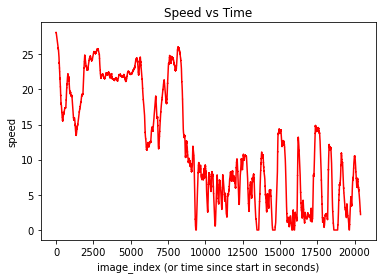

In [7]:
times = np.asarray(train_meta['image_index'], dtype = np.float32)
speeds = np.asarray(train_meta['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.xlabel('image_index (or time since start in seconds)')
plt.ylabel('speed')
plt.show()

In [6]:
# Run if you want to produce new training and validation data 
#train_data, valid_data = train_valid_split(train_meta, SEED)

100%|██████████| 10200/10200 [00:32<00:00, 317.12it/s]


In [7]:
# Create a dedicated training and validation set for all training purposes
#train_data.to_csv(os.path.join(CLEAN_DATA_PATH, 'train_data.csv'), index=False)
#valid_data.to_csv(os.path.join(CLEAN_DATA_PATH, 'valid_data.csv'), index=False)

# NOTE: You should use the same training and validation sets for fair model comparisons 
#       since randomness in training splits may lead to varied results. 
#       Uncomment the lines below to read data used to train models
train_data = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'train_data.csv'))
valid_data = pd.read_csv(os.path.join(CLEAN_DATA_PATH, 'valid_data.csv'))

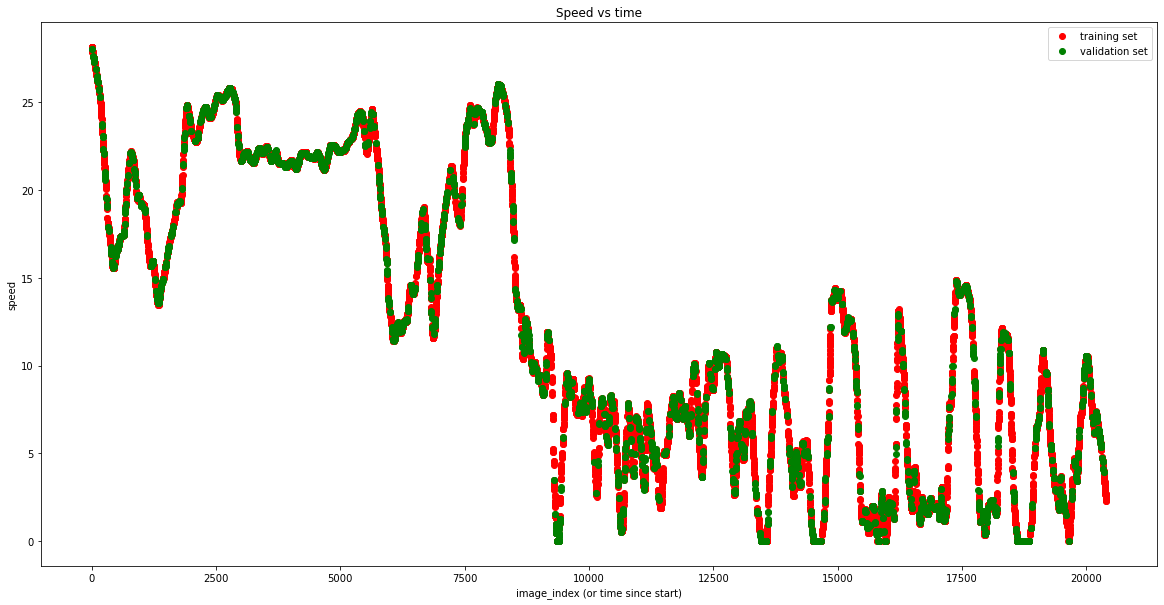

----
valid_data:        index                            image_path  image_index      speed
0     17048  data\clean_data\train_imgs/17048.jpg        17048   1.282385
1     17049  data\clean_data\train_imgs/17049.jpg        17049   1.279302
2     10983  data\clean_data\train_imgs/10983.jpg        10983   6.806907
3     10984  data\clean_data\train_imgs/10984.jpg        10984   6.786696
4     10576  data\clean_data\train_imgs/10576.jpg        10576   3.811775
...     ...                                   ...          ...        ...
3231  13232  data\clean_data\train_imgs/13232.jpg        13232   7.938766
3232   3974   data\clean_data\train_imgs/3974.jpg         3974  21.574175
3233   3975   data\clean_data\train_imgs/3975.jpg         3975  21.545134
3234    678    data\clean_data\train_imgs/678.jpg          678  18.802266
3235    679    data\clean_data\train_imgs/679.jpg          679  18.887023

[3236 rows x 4 columns]
valid_data:  (3236, 4)
train_data:         index                     

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(train_data.sort_values(['image_index'])[['image_index']], train_data.sort_values(['image_index'])[['speed']], 'ro')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], valid_data.sort_values(['image_index'])[['speed']], 'go')
#plt.plot(test_data.sort_values(['image_index'])[['image_index']], test_data.sort_values(['image_index'])[['speed']], 'bo')

plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('Speed vs time')
plt.legend(['training set', 'validation set', 'testing set'], loc='upper right')
plt.show()
plt.close()

print('----')
print('valid_data: ', valid_data)
print('valid_data: ', valid_data.shape)
print('train_data: ', train_data)
print('train_data: ', train_data.shape)
#print('test_data: ', test_data.shape)

original image shape: (480, 640, 3)


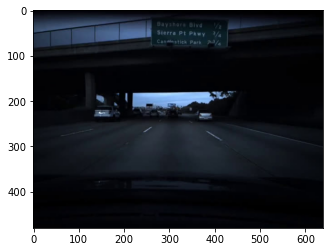

post prosessed image: (66, 220, 3)


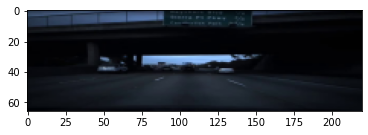

In [9]:
img=mpimg.imread(train_meta['image_path'][10])
print('original image shape:', img.shape)
plt.imshow(img)
plt.show()
plt.close()

post_img = preprocess_image(img)
print('post prosessed image:', post_img.shape)
plt.imshow(post_img)
plt.show()
plt.close()

In [9]:
train_generator = generate_training_data(train_data, batch_size = BATCH_SIZE)
next(train_generator)

(array([[[[-3.82922101e+00,  8.06106031e-02, -9.10899830e+00],
          [-6.44723701e+00,  1.40412554e-01, -1.53049688e+01],
          [-1.01600876e+01,  2.31057808e-01, -2.47231846e+01],
          ...,
          [-9.49253845e+00,  1.44607648e-01, -1.74975262e+01],
          [-9.01953125e+00,  1.31825745e-01, -1.66100445e+01],
          [-9.75923252e+00,  1.36682600e-01, -1.81787853e+01]],
 
         [[-3.31527710e+00,  7.30018988e-02, -7.88420486e+00],
          [-5.98892736e+00,  1.30510375e-01, -1.43561411e+01],
          [-9.89047241e+00,  2.20485181e-01, -2.42533703e+01],
          ...,
          [-9.19180298e+00,  1.39661208e-01, -1.60610390e+01],
          [-8.63445187e+00,  1.33914754e-01, -1.52662821e+01],
          [-9.65137672e+00,  1.48653120e-01, -1.75410690e+01]],
 
         [[-2.84584451e+00,  6.57854006e-02, -6.90746689e+00],
          [-4.88459969e+00,  1.15221336e-01, -1.20982399e+01],
          [-8.30229092e+00,  1.94843307e-01, -2.10430775e+01],
          ...,
    

In [10]:
valid_generator = generate_validation_data(valid_data, batch_size = BATCH_SIZE)
next(valid_generator)

(array([[[[-4.01602692e+02,  7.85376072e+00, -7.61814819e+02],
          [-5.13766968e+02,  9.72122765e+00, -9.42959106e+02],
          [-5.86846313e+02,  1.11785240e+01, -1.07313831e+03],
          ...,
          [ 6.55843496e-01, -6.11330681e+01, -7.93570633e+01],
          [ 5.39600670e-01, -5.03782082e+01, -6.36728783e+01],
          [ 4.34560895e-01, -4.60117188e+01, -5.47546730e+01]],
 
         [[-1.58442676e+03,  2.91510277e+01, -2.79849854e+03],
          [-1.64775500e+03,  2.96385078e+01, -2.84529688e+03],
          [-1.70818567e+03,  3.00762177e+01, -2.94746924e+03],
          ...,
          [ 4.81840754e+00, -5.15987244e+02, -5.73390503e+02],
          [ 3.44077706e+00, -3.68048828e+02, -4.23215576e+02],
          [ 2.51959658e+00, -2.68169342e+02, -3.17469177e+02]],
 
         [[-1.92307214e+03,  3.42801399e+01, -3.35945361e+03],
          [-1.92705566e+03,  3.37426796e+01, -3.34052539e+03],
          [-1.94958655e+03,  3.38760910e+01, -3.38760913e+03],
          ...,
    

 ## NVIDIA MODEL -- TRAIN

In [13]:
val_size = len(valid_data)//(BATCH_SIZE)

train_size = len(train_data)//(BATCH_SIZE)

steps_per_epoch = train_size


# run specific constants
model_name = 'nvidia' #nvidia2
run_name = 'model_{}_batch_size_{}_num_epoch_{}_steps_per_epoch_{}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          NUM_EPOCHS,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH,"model_assets", run_name)
weights_loc = os.path.join(assets_filepath,"weights.h5")
history_loc =  os.path.join(assets_filepath,"history.p")


earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

callbacks_list = [modelCheckpoint, earlyStopping]

In [14]:
# Check if current filepath name for saving weights matches hyper parameters and desired model
run_name

'model_nvidia_batch_size_32_num_epoch_25_steps_per_epoch_536'

In [15]:
def nvidia_model(N_img_height = 66, N_img_width = 220, N_img_channels = 3):
    inputShape = (N_img_height, N_img_width, N_img_channels)
    model = tf.Sequential()
    
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Conv2D(24, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Conv2D(36, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Conv2D(48, 5, 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Conv2D(64, 3,
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Conv2D(64, 3,
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = adam, loss = 'mean_squared_error')

    
    return model

In [16]:
model = nvidia_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 220, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 31, 108, 24)       1824      
_________________________________________________________________
elu (ELU)                    (None, 31, 108, 24)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 14, 52, 36)        21636     
_________________________________________________________________
elu_1 (ELU)                  (None, 14, 52, 36)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 5, 24, 48)         43248     
_________________________________________________________________
elu_2 (ELU)                  (None, 5, 24, 48)         0

In [19]:
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = NUM_EPOCHS,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
536/536 [==============================] - ETA: 0s - loss: 25.7333WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000012E96132C18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [22]:
pickle.dump(history.history, open(history_loc, "wb"))

# NVIDIA MODEL -- Analysis

In [18]:
predict_speed(valid_data, model)

  0%|          | 0/3234 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 3234/3234 [02:39<00:00, 20.27it/s]


In [43]:
print(mean_squared_error(valid_data.iloc[1:-1, 3][~np.isnan(valid_data.iloc[1:-1, 3])], 
                         valid_data.iloc[1:-1, 4].fillna(0)))

2.4211618158914723


dict_keys(['loss', 'val_loss'])


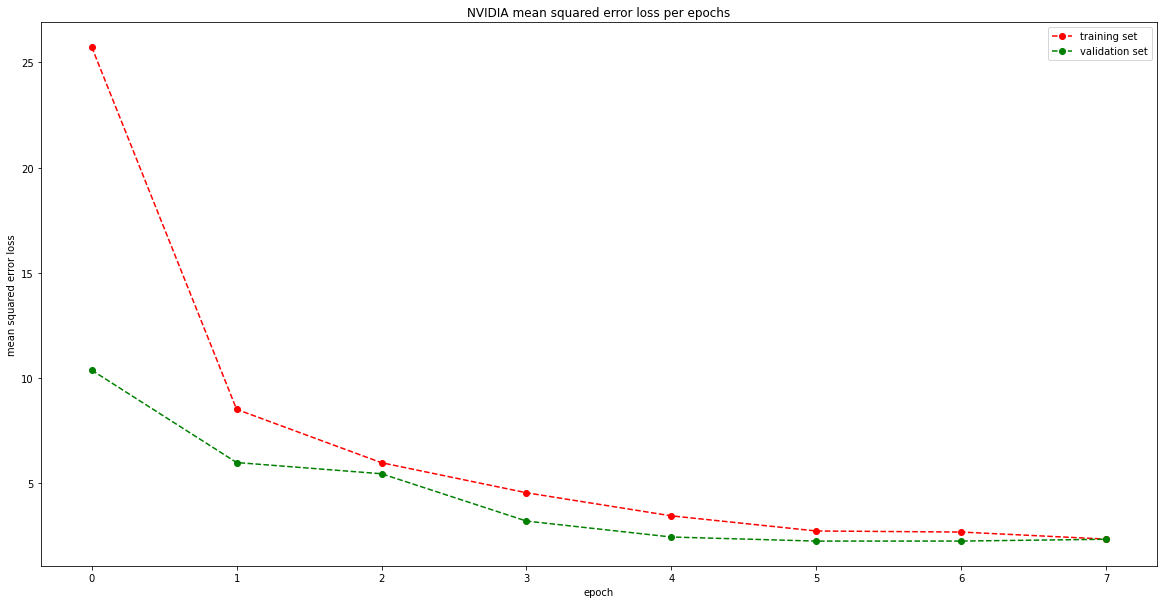

In [23]:
print(history.history.keys())

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('NVIDIA mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

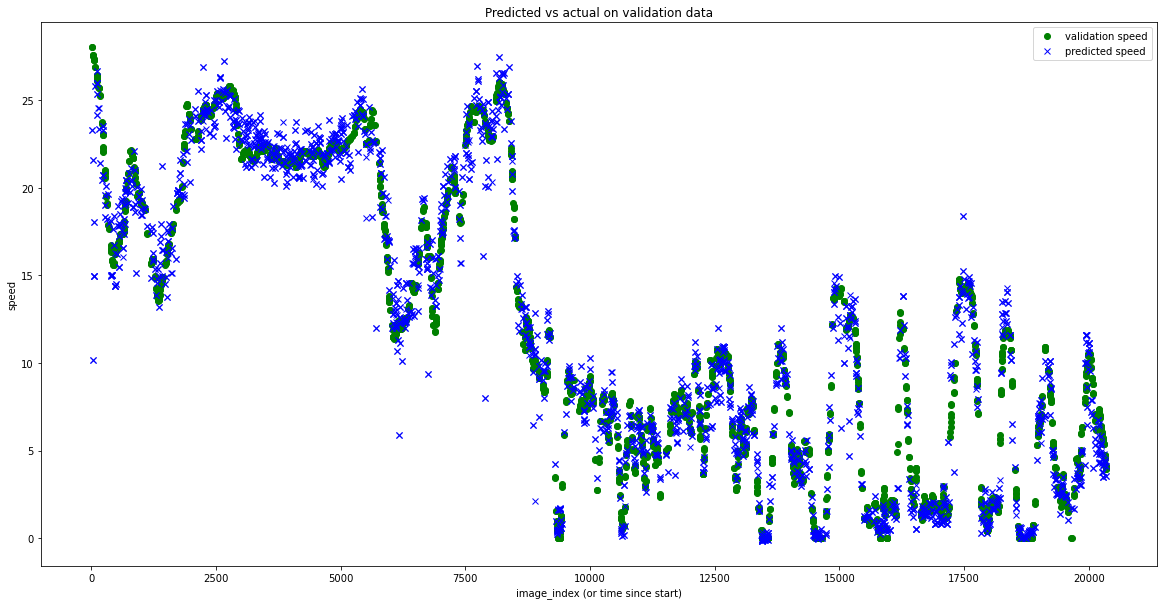

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('NVIDIA Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

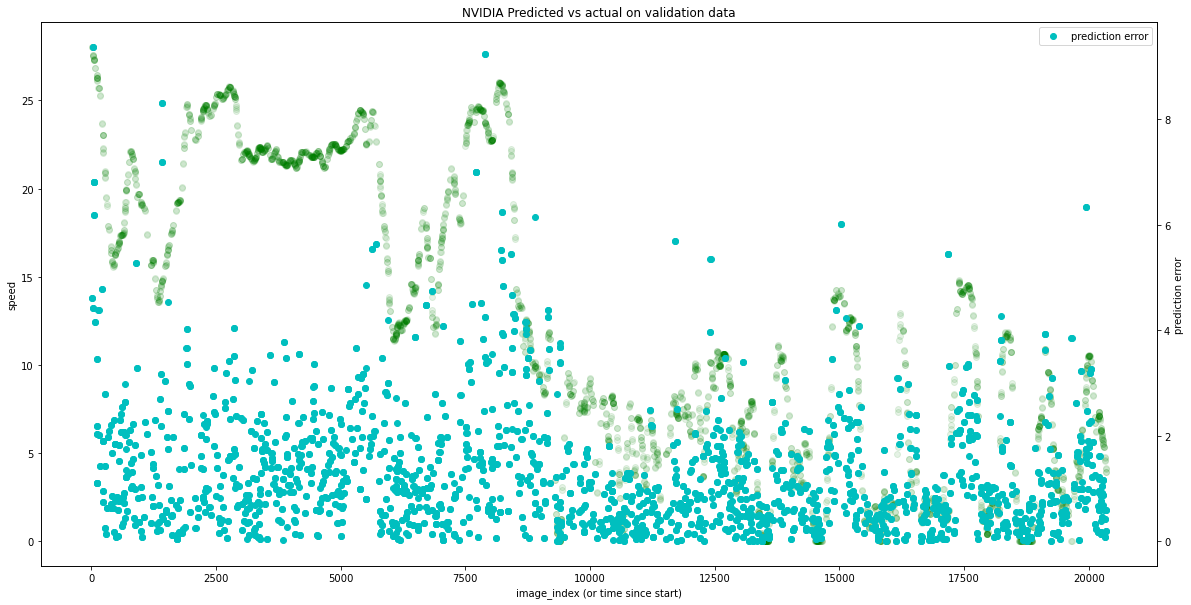

In [20]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')
ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('NVIDIA Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()

<hr style="border:2px solid gray"> </hr>

# FlowNetS MODEL -- TRAIN

In [11]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def flowNetS_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)
    model = tf.Sequential()
    
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Conv2D(64,(3,3),
                   padding='same',
                   kernel_initializer = 'he_normal',
                   name='conv0'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(64,(3,3),strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv1'))
    model.add(ELU())
    
    model.add(Conv2D(128,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv1_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(128,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv2'))
    model.add(ELU())
    
    model.add(Conv2D(128,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv2_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(256,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv3'))
    model.add(ELU())
    
    model.add(Conv2D(256,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv3_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv4'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv4_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(512,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv5'))
    model.add(ELU())
    
    model.add(Conv2D(512,(3,3),
                     strides=(1,1),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv5_1'))
    model.add(ELU())
    model.add(ZeroPadding2D())
    
    model.add(Conv2D(1024,(3,3),
                   strides=(2,2),
                   padding='valid',
                   kernel_initializer = 'he_normal',
                   name='conv6'))
    model.add(ELU())
    
    model.add(Conv2D(1024,(3,3),
                     padding='same',
                     kernel_initializer = 'he_normal',
                     name='conv6_1'))
    model.add(ELU())
    
    model.add(Conv2D(2,(3,3),padding='same',name='predict_flow'))
    model.add(ELU())
    model.add(Flatten(name = 'flatten'))
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer = adam, loss = 'mean_squared_error')

    
    return model

In [12]:
BATCH_SIZE = 64
train_generator = generate_training_data(train_data, batch_size = BATCH_SIZE)
next(train_generator)

(array([[[[-1.59524179e+00,  2.52127144e-02, -2.82382393e+00],
          [-2.45201659e+00,  3.90863344e-02, -4.37766933e+00],
          [-4.04622507e+00,  6.42331392e-02, -7.45104408e+00],
          ...,
          [-1.73549354e+00,  2.48663090e-02, -3.38181806e+00],
          [-1.23825228e+00,  1.61805153e-02, -2.39471626e+00],
          [-5.87672651e-01,  7.40452344e-03, -1.09586942e+00]],
 
         [[-1.53410447e+00,  2.01037936e-02, -2.29183245e+00],
          [-2.11575270e+00,  2.79837493e-02, -3.10619617e+00],
          [-3.28361249e+00,  4.75821681e-02, -5.13887405e+00],
          ...,
          [-1.93905091e+00,  2.61747632e-02, -3.69064164e+00],
          [-1.18051124e+00,  1.65738817e-02, -2.22090006e+00],
          [-6.34158731e-01,  7.60826375e-03, -1.13363135e+00]],
 
         [[-1.46631873e+00,  1.60425752e-02, -1.81281102e+00],
          [-2.12931991e+00,  2.32549589e-02, -2.58130050e+00],
          [-3.23617244e+00,  3.97112146e-02, -4.28881121e+00],
          ...,
    

In [13]:
BATCH_SIZE = 64
valid_generator = generate_validation_data(valid_data, batch_size = BATCH_SIZE)
next(valid_generator)

(array([[[[ 4.29691792e-01, -4.26044579e+01, -4.72660980e+01],
          [ 7.37193227e-01, -7.39706116e+01, -8.03540649e+01],
          [ 1.05814171e+00, -1.06016678e+02, -1.14279305e+02],
          ...,
          [-1.06650497e+02,  1.70320880e+00, -2.14604309e+02],
          [-7.84827728e+01,  1.17279756e+00, -1.57154877e+02],
          [-5.06559029e+01,  7.34977305e-01, -1.01426865e+02]],
 
         [[ 6.22147560e-01, -6.33301849e+01, -6.65697861e+01],
          [ 9.95107174e-01, -1.03586456e+02, -1.07471573e+02],
          [ 1.34017813e+00, -1.36057831e+02, -1.39378525e+02],
          ...,
          [-1.17558807e+02,  1.91395068e+00, -2.31588028e+02],
          [-8.30072327e+01,  1.31083488e+00, -1.62543518e+02],
          [-5.45912666e+01,  8.28446746e-01, -1.06869629e+02]],
 
         [[ 7.58409917e-01, -8.08248520e+01, -8.19082718e+01],
          [-1.20836533e+02,  1.13996732e+00,  8.92687619e-01],
          [-1.54569443e+02,  1.48624468e+00, -2.41110706e+00],
          ...,
    

In [14]:
val_size = len(valid_data)//(BATCH_SIZE)

train_size = len(train_data)//(BATCH_SIZE)

steps_per_epoch = train_size

# run specific constants
model_name = 'flowNetS' 
run_name = 'model_{}_batch_size_{}_num_epoch_{}_steps_per_epoch_{}'.format(model_name,
                                                                          BATCH_SIZE,
                                                                          NUM_EPOCHS,
                                                                          steps_per_epoch)

assets_filepath = os.path.join(ASSETS_PATH,"model_assets", run_name)
weights_loc = os.path.join(assets_filepath,"weights.h5")
history_loc =  os.path.join(assets_filepath,"history.p")


earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min')

modelCheckpoint = ModelCheckpoint(weights_loc, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)

callbacks_list = [modelCheckpoint, earlyStopping]

In [15]:
run_name

'model_flowNetS_batch_size_64_num_epoch_25_steps_per_epoch_268'

In [16]:
model = flowNetS_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 66, 220, 3)        0         
_________________________________________________________________
conv0 (Conv2D)               (None, 66, 220, 64)       1792      
_________________________________________________________________
elu (ELU)                    (None, 66, 220, 64)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 68, 222, 64)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 33, 110, 64)       36928     
_________________________________________________________________
elu_1 (ELU)                  (None, 33, 110, 64)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 33, 110, 128)      7

In [32]:
history = model.fit(
        train_generator, 
        steps_per_epoch = steps_per_epoch, 
        epochs = NUM_EPOCHS,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
268/268 [==============================] - ETA: 0s - loss: 20.3523WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000001EEB3722948> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the f

In [41]:
pickle.dump(history.history, open(history_loc, "wb"))

# FlowNetS -- ANALYSIS

In [36]:
predict_speed(valid_data, model)

  0%|          | 0/3234 [00:00<?, ?it/s]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


100%|██████████| 3234/3234 [03:27<00:00, 15.58it/s]


In [37]:
print(mean_squared_error(valid_data.iloc[1:-1, 3][~np.isnan(valid_data.iloc[1:-1, 3])], 
                         valid_data.iloc[1:-1, 4].fillna(0)))

1.4957587941237553


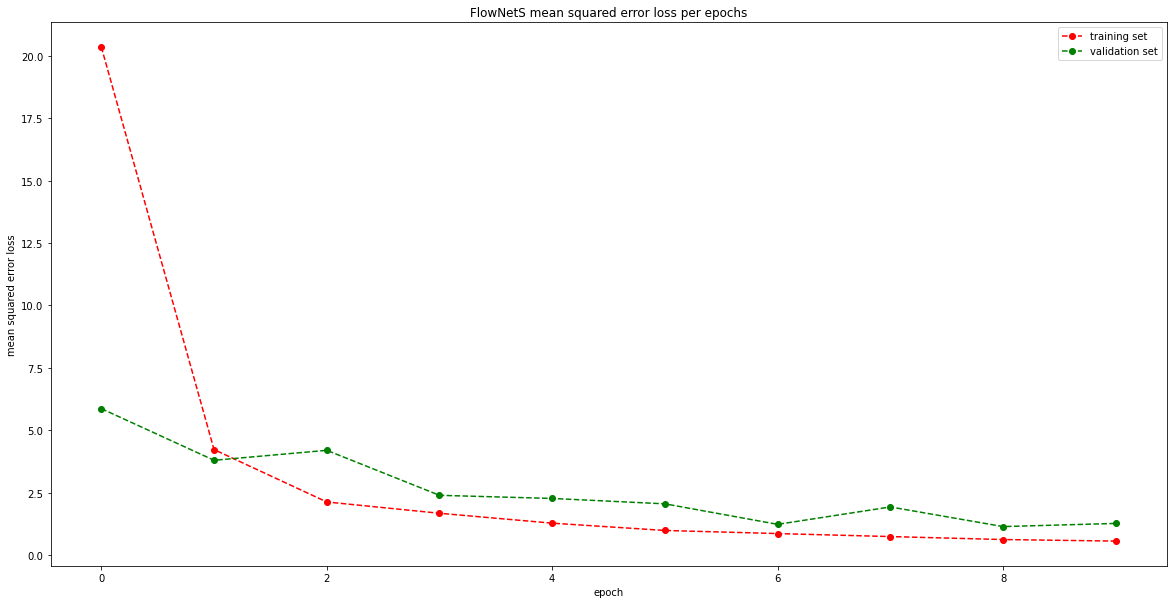

In [38]:
#print(history.history.keys())

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history.history['loss'], 'ro--')
plt.plot(history.history['val_loss'], 'go--')
plt.title('FlowNetS mean squared error loss per epochs')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.close()

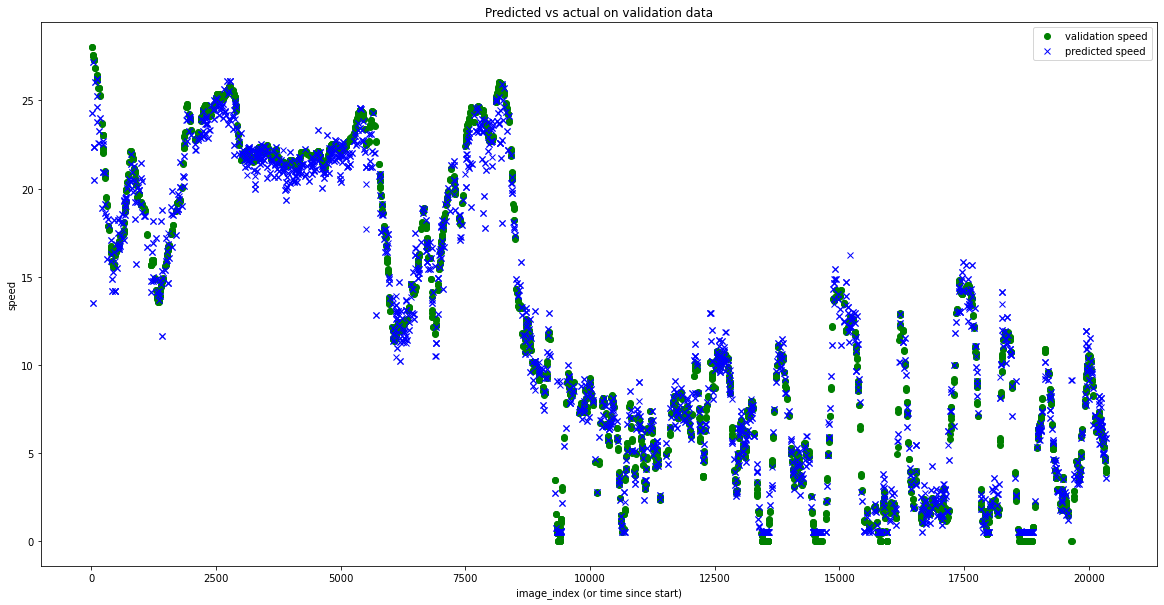

In [39]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go')
plt.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['predicted_speed']], 'bx')
plt.xlabel('image_index (or time since start)')
plt.ylabel('speed')
plt.title('FlowNetS Predicted vs actual on validation data')
plt.legend(['validation speed', 'predicted speed'], loc='upper right')
plt.show()
plt.close()

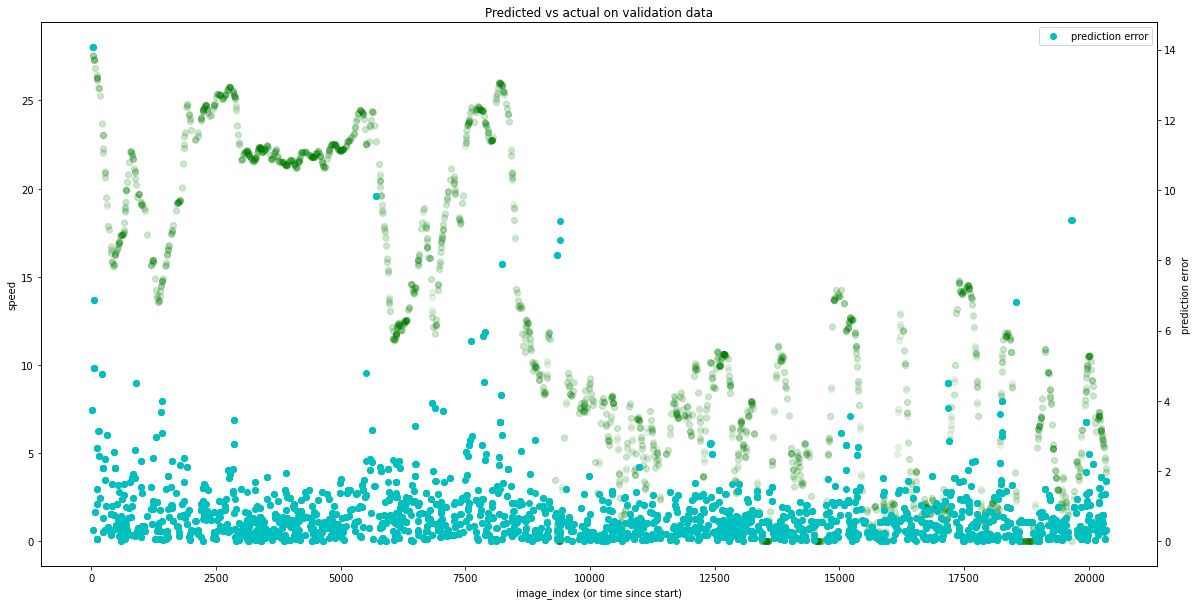

In [40]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax1.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['speed']], 'go', alpha=0.1)

ax2 = ax1.twinx()
ax2.plot(valid_data.sort_values(['image_index'])[['image_index']], 
         valid_data.sort_values(['image_index'])[['error']], 'co')
ax1.set_xlabel('image_index (or time since start)')
ax1.set_ylabel('speed')
ax2.set_ylabel('prediction error')
plt.title('FlowNetS Predicted vs actual on validation data')
plt.legend(['prediction error'], loc='upper right')
plt.show()
plt.close()